# Array Compare $\psi_4$ data with low and high level MMRDNS Models

### Setup The Enviroment

In [2]:
# Low-level import 
from numpy import array,loadtxt,linspace,zeros,exp,ones,unwrap,angle,pi

# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Import useful things from kerr
from kerr.formula.ksm2_cw import CW as cwfit
from kerr.formula.ksm2_sc import SC as scfit
from kerr.pttools import leaver_workfunction as lvrwork
from kerr import leaver,rgb
from kerr.models import mmrdns 

#
from nrutils import scsearch,gwylm,gwf

# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
from matplotlib.pyplot import *

### Define master plotting function

In [12]:
def plot_comparison(ll,mm,q,T0,ax):
    
    # Load the data
    data_file_string = '/Users/book/GARREG/Spectroscopy/Ylm_Depictions/NonPrecessing/MULTI_DATA_6/T0_%i_nmax2_Mmin97ll_Mmin_r75_qref1.50__p1_17-Mar-2014gnx_/Data_Sets/HRq-series/D9_q%1.1f_a0.0_m160/DEPICTION_INFO::NODD_INPUT_ll%i_mm%i_r75.asc'%(T0,q,ll,mm)
    data = loadtxt(data_file_string)

    # Collect raw fit data for later convenience
    rfdata = {}
    for k,row in enumerate(data):
        #
        ll,mm,q,m1,m2,x1,x2,jf,Mf,qid,rew,imw,rewfit,imwfit,reA,imA,reAmean,imAmean,minA,maxA,T1,dT,match,rmse,reB,imB,reBmean,imBmean,minB,maxB = row
        ll,mm = int(ll),int(mm)
        A = reA+1j*imA
        cw = rew + 1j*imw
        try:
            l,m,n,p = mmrdns.calc_z(qid)
        except:
            l,m,n,p,l2,m2,n2,p2 = mmrdns.calc_z(qid)
        rfdata[(l,m,n,p)] = {}
        rfdata[(l,m,n,p)]['ll'],rfdata[(l,m,n,p)]['mm'],rfdata[(l,m,n,p)]['A'],rfdata[(l,m,n,p)]['cw'] = ll,mm,A,cw
        
    # Print the relative phase
    print angle( rfdata[(max(mm,2),mm,0,1)]['A'] * rfdata[(ll,mm,0,1)]['A'].conj() )
    print angle( mmrdns.Afit(2,2,0,mmrdns.q2eta(q))  * mmrdns.Afit(3,2,0,mmrdns.q2eta(q)).conj() )
    
    # Define function to calculate raw fit
    def rawfit(t):
        y = zeros( t.shape, dtype=complex )
        for k,row in enumerate(data):
            #
            ll,mm,q,m1,m2,x1,x2,jf,Mf,qid,rew,imw,rewfit,imwfit,reA,imA,reAmean,imAmean,minA,maxA,T1,dT,match,rmse,reB,imB,reBmean,imBmean,minB,maxB = row
            ll,mm = int(ll),int(mm)
            A = reA+1j*imA
            cw = rew + 1j*imw
            try:
                l,m,n,p = mmrdns.calc_z(qid)
            except:
                l,m,n,p,l2,m2,n2,p2 = mmrdns.calc_z(qid)
            # NOTE that the amplitudes are for Psi4 here
            if True: # (l,m,n,p) in [ (2,2,0,1) ,(2,2,1,1) ]  :
                u = 1.0/(1j*cw)
                y += u*u*A*exp( 1j*cw*(t-T0) )

        #
        a = gwf( array( [t,y.real,-y.imag] ).T )

        #
        return a,q

    _,q = rawfit( linspace(T0,50) )

    #
    # A = scsearch( keyword='hrq',notkeyword='athena', q=q, nonspinning=True,verbose=True )[0]
    A = scsearch( keyword=['hr','athena'], q=q, nonspinning=True,verbose=True )[0]

    #
    imrnr = gwylm( A, lm=([ll,mm],[2,2]), verbose=True, dt=0.5 )
    nr = imrnr.ringdown(T0=T0,use_peak_strain=False,T1=160)

    y,_ = rawfit( nr.lm[(ll,mm)]['strain'].t )

    #
    eta = mmrdns.q2eta(q)
    h = mmrdns.meval_spherical_mode(ll,mm,eta,kind='strain',gwfout=True)(nr.ylm[0].t)

    h.align(nr.lm[(ll,mm)]['strain'],method='average-phase',mask=nr.ylm[0].t<60)
    y.align(nr.lm[(ll,mm)]['strain'],method='average-phase',mask=nr.ylm[0].t<60)

#     nr.lm[(ll,mm)]['psi4'].plot()
#     y.plot()
#     h.plot()

    #fig = figure( figsize=2*array([5,3]) )
    sca(ax)
    ax.set_yscale("log", nonposy='clip')

    plot( nr.ylm[0].t, nr.lm[(ll,mm)]['strain'].amp, color=0.5*ones((3,)), label=None )
    plot( nr.ylm[0].t, y.amp, '--k', label=None )
    plot( nr.ylm[0].t, h.amp, 'k', alpha=0.2, linewidth=6, label=None )

    plot( nr.ylm[0].t, nr.lm[(ll,mm)]['strain'].plus, color=0.5*ones((3,)), label='NR' )
    plot( nr.ylm[0].t, y.plus, '--k', label='RAW-FIT' )
    plot( nr.ylm[0].t, h.plus, 'k', alpha=0.2, linewidth=6,label='MMRDNS' )

    # plot( nr.ylm[0].t, nr.lm[(ll,mm)]['strain'].cross, color=0.5*ones((3,)), label='NR', alpha=0.8 )
    # plot( nr.ylm[0].t, y.cross, '--k', label='RAW-FIT', alpha=0.8 )
    # plot( nr.ylm[0].t, h.cross, 'k', alpha=0.1, linewidth=6, label='MMRDNS' )

    ylim( [max(nr.lm[(ll,mm)]['strain'].amp)*1e-5,1.2*max(nr.lm[(ll,mm)]['strain'].amp)] )
    xlim( [T0,150] )

    xlabel(r'$(t-\mathrm{argmax}_t(\dot{h}(t)))/M$')
    ylabel(r'$h_{%i%i}$'%(ll,mm))

    legend(frameon=False)
    title( nr.label )

### Define parameter ranges

In [13]:
T0_range = [10]
llmm_range = [ (2,2), (2,1), (3,3), (3,2), (4,4), (4,3), (5,5) ]
q_range = [ 1.2, 4 ]

0.0
0.105648637365
(scsearch)>> Found keyword (=['hr', 'athena']) keyword.
(scsearch)>> Found nonspinning (=True) keyword.
(scsearch)>> Found q (=1.2000021999999999) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][bradwr] HRq-series: ns-q1.20	(D9_q1.2_a0.0_m160)

(gwylm)>> Found dt (=0.5) keyword.
(gwylm)>> Found lm (=([2, 2], [2, 2])) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x10be5f050>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(validate!)>> Multiple catalog directories found. We will scan through the related list, and then store first the catalog_dir that the OS can find.
(validate!)>> Selecting "/Volumes/athena/bradwr/"
(gwylm)>> The (extraction_parameter,level) is (75.0,None), which 

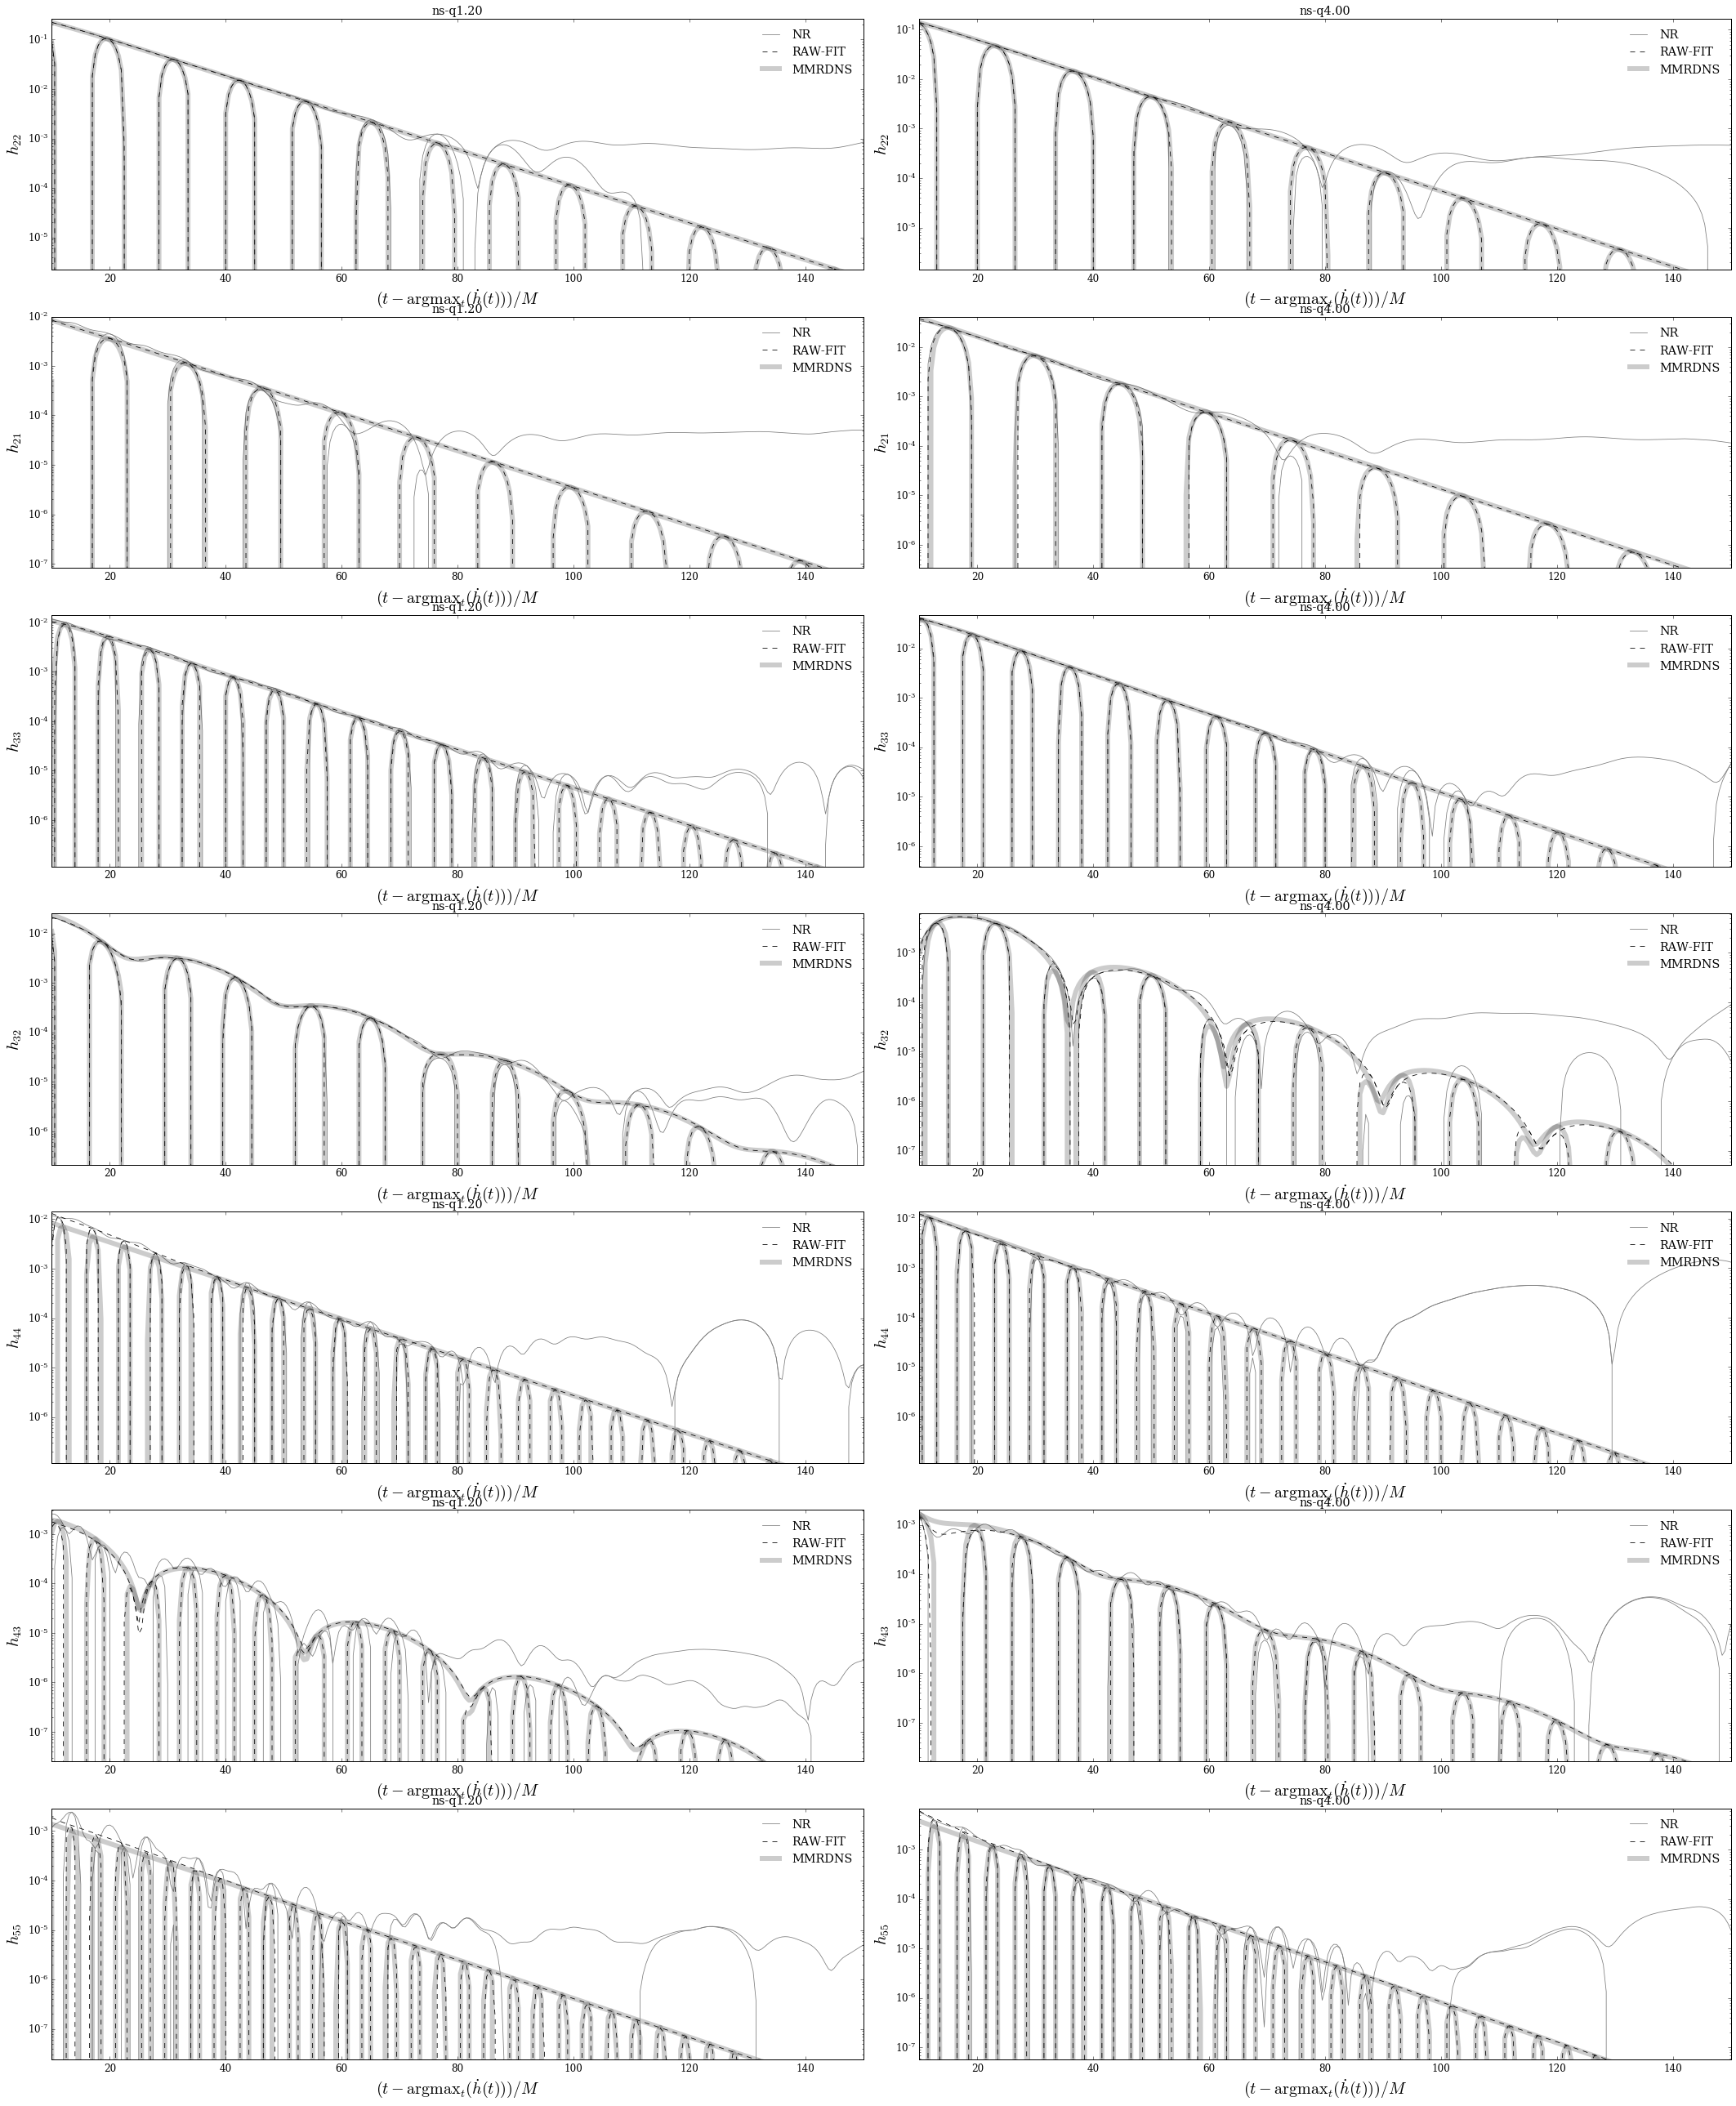

In [14]:
#
fig,axarr = subplots( len(llmm_range), len(q_range),figsize=6*array( [5,6] ))
tight_layout(pad=3, w_pad=3, h_pad=3)

#
for T0 in T0_range:
    for k,(ll,mm) in enumerate(llmm_range):
        for h,q in enumerate(q_range):
            #
            ax = axarr[k,h]
            plot_comparison(ll,mm,q,T0,ax)

savefig('compare_strain.pdf')